## Toy Model 1: 2 spatial modes with different oscillating frequencies

### Created by Yuying Liu, 09/23/2019

$$\Phi(x, t) = u(x)cos(\omega_0 t) + v(x)cos(\omega_1 t + \frac{\pi}{4})$$

In [24]:
# imports
import os
import sys
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import torch_cae_multilevel_V4 as net
from utils import *

## Simulation 

In [2]:
# params
w0 = 0.5
w1 = 4.0
sigma0 = 10.0
sigma1 = 0.25

In [3]:
# define two modes
def phi1(x, y, t):
    return 1./np.cosh((x+1)/sigma0)/np.cosh((y-1)/sigma0)*np.cos(w0*t)

def phi2(x, y, t):
    return 1./(sigma1*np.sqrt(2*np.pi))*np.exp(-((x-1)**2+(y+1)**2)/(2*sigma1**2))*np.cos(w1*t + np.pi/4)

In [9]:
# mesh grids
x = np.linspace(-5, 5, 127)
y = np.linspace(-5, 5, 127)
t = np.linspace(0, 8*np.pi, 500)
xgrid, ygrid, tgrid = np.meshgrid(x, y, t)

In [10]:
# data
Phi = phi1(xgrid, ygrid, tgrid) + phi2(xgrid, ygrid, tgrid)
scaled_Phi = (Phi - Phi.min()) / (Phi.max() - Phi.min())
print(Phi.shape)

# np.save(data_path, scaled_Phi.T)

(127, 127, 500)


## MrCAE

Below is the progressive training framework. 
One could have flexible control over each training step: low-level models are cheap to obtain, and higher level models are built based on them -- one can always revert back to the previous level and adjust the parameters to re-train the model if it is not satisfying. 

In [65]:
# init model & load data
data_path = '../data/toy1.npy'
model_path = '../model/toy1b/'
result_path = '../result/toy1b/'

dataset = net.MultiScaleDynamicsDataSet(data_path, n_levels=5)

In [158]:
# training
archs = [[1,2], [1,2], [1,2],[1], [1]]#,2,3,4],[1,2,3,4],[1,3,5,7]]
tols = [0.00001, 0.001, 0.001, 0.0005, 0.0001]
net.train_net(archs=archs, dataset=dataset, max_epoch=2000, batch_size=350, 
              tols=tols, activation=torch.nn.Sequential(), w=0.5, model_path=model_path, 
              result_path=result_path, std=0.01, verbose=2)

*************************************************
Model @Level 0:
Perform deepening & widening, train each architectures ...
model layers: 
['activation', 'L0_Conv_0', 'L0_deConv_0']
losses printing format: local: mse/max/overall, global: mse/max/overall
epoch [1/2000]
[training set] local: 0.0037/0.0081/0.0059, global: 0.0037/0.0531/0.0284
[validation set] local: 0.0037/0.0075/0.0056, global: 0.0037/0.0502/0.0269
epoch [200/2000]:
[training set] local: 0.0001/0.0047/0.0024, global: 0.0002/0.0479/0.0240
[validation set] local: 0.0001/0.0046/0.0024, global: 0.0002/0.0472/0.0237
epoch [400/2000]:
[training set] local: 0.0001/0.0050/0.0025, global: 0.0002/0.0517/0.0259
[validation set] local: 0.0001/0.0045/0.0023, global: 0.0002/0.0466/0.0234
epoch [600/2000]:
[training set] local: 0.0001/0.0043/0.0022, global: 0.0002/0.0465/0.0233
[validation set] local: 0.0001/0.0043/0.0022, global: 0.0002/0.0460/0.0231
epoch [800/2000]:
[training set] local: 0.0001/0.0044/0.0022, global: 0.0002/0.0484/

KeyboardInterrupt: 

In [66]:
# trained models at different levels
models = {}
print('model names: model_L{level}_{index}')
for file_name in sorted(os.listdir(model_path)):
    model_name, _ = file_name.split('.')
    print(model_name)
    models[model_name] = torch.load(os.path.join(model_path, file_name))

model names: model_L{level}_{index}
model_L0_0


torch.Size([500, 1, 127, 127])
data_this.shape =  torch.Size([500, 1, 7, 7])
level =  0
x shape =  torch.Size([500, 1, 7, 7])
torch.Size([500, 1, 3, 3])


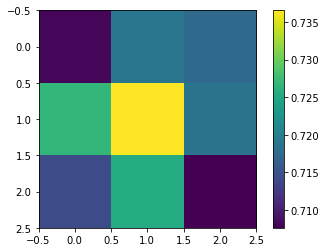

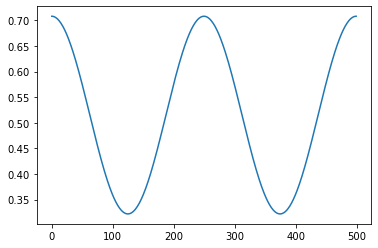

level =  0


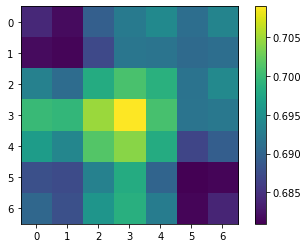

(500,)


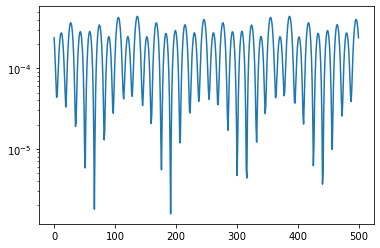

In [67]:
def obtain_data_at_current_level(data, level,n_levels):
#         train_data = self.data[self.train_inds].to(self.device)
#         val_data = self.data[self.val_inds].to(self.device)
#         test_data = self.data[self.test_inds].to(self.device)
        device = 'cuda' if torch.cuda.is_available() else 'cpu'

        for _ in range(n_levels - level - 1):
            data = utils.apply_local_op(data, device, ave=False)

        return data
    
model = models['model_L0_0']
data = torch.tensor(scaled_Phi).T.unsqueeze(1).float()[:500]
print(data.shape)
data_this = obtain_data_at_current_level(data, 0,5)
print("data_this.shape = ", data_this.shape )
encoded = model.encode(data_this, 0)#, query_in_out_each_level=False, query_hidden=False)
print(encoded.shape)

plt.imshow(encoded[0,0].detach().numpy())
plt.colorbar()
plt.show()

plt.plot(encoded[:,0,0,0].detach().numpy())
plt.show()

decoded = model.decode(encoded, 0)

plt.imshow(decoded[0,0].detach().numpy())
plt.colorbar()
plt.show()

mse = np.mean(((data_this - decoded)**2).detach().numpy(), axis=(1,2,3))

print(mse.shape)
plt.semilogy(mse)

data_this.shape =  torch.Size([500, 1, 7, 7])
level =  0
x shape =  torch.Size([500, 1, 7, 7])
level =  0


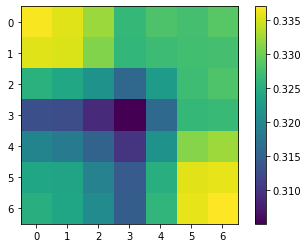

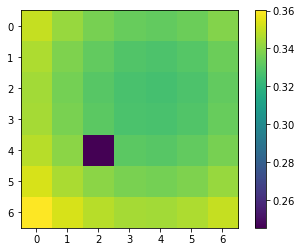

(7, 7)


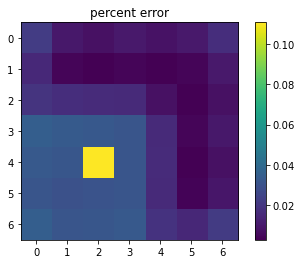

In [70]:
model = models['model_L0_0']
level = 0
# data = torch.tensor(scaled_Phi).T.unsqueeze(1).float()
data_this = obtain_data_at_current_level(data, level,5)
print("data_this.shape = ", data_this.shape )
encoded = model.encode(data_this, level)#, query_in_out_each_level=False, query_hidden=False)


decoded = model.decode(encoded, level)

plt.imshow(decoded[103,0].detach().numpy())
plt.colorbar()
plt.show()

plt.imshow(data_this[103,0])
plt.colorbar()
plt.show()

mse = np.mean((np.abs(((data_this - decoded)/data_this).detach().numpy())), axis=(0,1))

plt.imshow(mse)
plt.title("percent error")
plt.colorbar()
print(mse.shape)
# plt.plot(mse)

data_this.shape =  torch.Size([500, 1, 7, 7])
level =  0
x shape =  torch.Size([500, 1, 7, 7])
encoded.shape =  torch.Size([500, 1, 3, 3])
level =  0
torch.Size([499, 1, 7, 7])


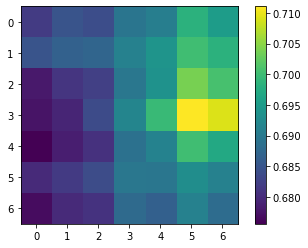

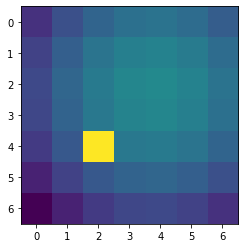

In [131]:
data_this = obtain_data_at_current_level(data, 0,5)
print("data_this.shape = ", data_this.shape)
predicted = model.predict_in_middle(data_this, 0)
print(predicted.shape)
plt.imshow(predicted[0,0].detach().numpy())
plt.colorbar()
plt.show()

plt.imshow(data_this[1,0])

# mse = np.mean(((data_this - decoded)**2).detach().numpy(), axis=(1,2,3))

# print(mse.shape)
# plt.semilogy(mse)

# mse = np.mean(((data_this[1:] - predicted)**2).detach().numpy(), axis=(1,2,3))

# print(mse.shape)
# plt.semilogy(mse)

In [57]:
def encode(self, x, level, query_in_out_each_level=False, query_hidden=False):
        """
        :param x: a 4D input of NN
        :param level: level index
        :param query_in_out_each_level: if to query the input/output at each level
        (maybe used for enforce losses at different levels)
        :param query_hidden: if to query hidden representations
        :return: output of NN, a list of hidden representations at current level
        """
        # collectors
        all_hidden = dict()
        all_inputs = dict()
        all_outputs = dict()

        # forward prop
        assert level >= 0, print('level index should be a non-negative integer!')
        resolved_maps_dict = self.resolved_maps[str(level)]

        # print("level = ", level)
        # print("x shape = ", x.shape)
#         if level == 0:
        if self.n_filter_groups_each_level['0'] == 1:
            if query_in_out_each_level:
                all_inputs['0'] = x
            encoded = self._modules['L{}_Conv_0'.format(level)](x)

            print("return encoded")
            return encoded
#             if query_hidden:
#                 all_hidden['L0_0'] = encoded
#             # ----- pad -----
#             encoded = torch.nn.functional.pad(encoded, (1, 1, 1, 1), 'replicate')
#             # ---------------
#             y = self._modules['L{}_deConv_0'.format(level)](encoded)
#             # chop off the boundaries
#             y = y[:, :, 2:-2, 2:-2]
#         else:
#         for i in range(1, self.n_filter_groups_each_level['0']):
        i = self.n_filter_groups_each_level['0']-1
        encoded = self._modules['L{}_Conv_{}'.format(level, i)](x)
        if self.use_maps:
            masked_encoded = apply_mask(encoded, resolved_maps_dict[str(i - 1)])
        else:
            masked_encoded = encoded
        return masked_encoded
#             if query_hidden:
#                 all_hidden['L0_{}'.format(i)] = masked_encoded
#             y += self._modules['L0_deConv_{}'.format(i)](masked_encoded)
#         if query_in_out_each_level:
#             all_outputs['0'] = y
#         else:
#             encoded = self._modules['L{}_Conv_0'.format(level)](x)
#             decoded, ins, outs, hs = \
#                 self.forward(encoded, level-1, query_in_out_each_level, query_hidden)
#             # ----- pad -----
#             decoded = torch.nn.functional.pad(decoded, (1, 1, 1, 1), 'replicate')
#             # ---------------
#             if query_in_out_each_level:
#                 all_inputs[str(level)] = x
#                 all_inputs.update(ins)
#                 all_outputs.update(outs)
#             if query_hidden:
#                 all_hidden.update(hs)
#                 all_hidden['L{}_0'.format(level)] = encoded
#             y = self._modules['L{}_deConv_0'.format(level)](decoded)
#             y = y[:, :, 2:-2, 2:-2]
#             for i in range(1, self.n_filter_groups_each_level[str(level)]):
#                 encoded = self._modules['L{}_Conv_{}'.format(level, i)](x)
#                 if self.use_maps:
#                     masked_encoded = apply_mask(encoded, resolved_maps_dict[str(i - 1)])
#                 else:
#                     masked_encoded = encoded
#                 if query_hidden:
#                     all_hidden['L{}_{}'.format(level, i)] = masked_encoded
#                 y += self._modules['L{}_deConv_{}'.format(level, i)](masked_encoded)
#             if query_in_out_each_level:
#                 all_outputs[str(level)] = y

#         return y, all_inputs, all_outputs, all_hidden
    
def decode(self, encoded, level, y=None, query_in_out_each_level=False, query_hidden=False):
        """
        :param x: a 4D input of NN
        :param level: level index
        :param query_in_out_each_level: if to query the input/output at each level
        (maybe used for enforce losses at different levels)
        :param query_hidden: if to query hidden representations
        :return: output of NN, a list of hidden representations at current level
        """
        # collectors
        all_hidden = dict()
        all_inputs = dict()
        all_outputs = dict()

        # forward prop
        assert level >= 0, print('level index should be a non-negative integer!')
        resolved_maps_dict = self.resolved_maps[str(level)]

        # print("level = ", level)
        # print("x shape = ", x.shape)
#         if level == 0:
        if self.n_filter_groups_each_level['0'] == 1:
#             if query_in_out_each_level:
#                 all_inputs['0'] = x
#             encoded = self._modules['L0_Conv_0'](x)
            if query_hidden:
                all_hidden['L0_0'] = encoded
            # ----- pad -----
            encoded = torch.nn.functional.pad(encoded, (1, 1, 1, 1), 'replicate')
            # ---------------
            y = self._modules['L{}_deConv_0'.format(level)](encoded)
            # chop off the boundaries
            y = y[:, :, 2:-2, 2:-2]
        else:# self.n_filter_groups_each_level['0']):
#                 encoded = self._modules['L0_Conv_{}'.format(i)](x)
#                 if self.use_maps:
#                     masked_encoded = apply_mask(encoded, resolved_maps_dict[str(i - 1)])
#                 else:
#                     masked_encoded = encoded
#                 if query_hidden:
#                     all_hidden['L0_{}'.format(i)] = masked_encoded
            y += self._modules['L{}_deConv_{}'.format(level, self.n_filter_groups_each_level['0'] -1)](encoded)
            if query_in_out_each_level:
                all_outputs['0'] = y
        return y
#         else:
#             encoded = self._modules['L{}_Conv_0'.format(level)](x)
#             decoded, ins, outs, hs = \
#                 self.forward(encoded, level-1, query_in_out_each_level, query_hidden)
#             # ----- pad -----
#             decoded = torch.nn.functional.pad(decoded, (1, 1, 1, 1), 'replicate')
#             # ---------------
#             if query_in_out_each_level:
#                 all_inputs[str(level)] = x
#                 all_inputs.update(ins)
#                 all_outputs.update(outs)
#             if query_hidden:
#                 all_hidden.update(hs)
#                 all_hidden['L{}_0'.format(level)] = encoded
#             y = self._modules['L{}_deConv_0'.format(level)](decoded)
#             y = y[:, :, 2:-2, 2:-2]
#             for i in range(1, self.n_filter_groups_each_level[str(level)]):
#                 encoded = self._modules['L{}_Conv_{}'.format(level, i)](x)
#                 if self.use_maps:
#                     masked_encoded = apply_mask(encoded, resolved_maps_dict[str(i - 1)])
#                 else:
#                     masked_encoded = encoded
#                 if query_hidden:
#                     all_hidden['L{}_{}'.format(level, i)] = masked_encoded
#                 y += self._modules['L{}_deConv_{}'.format(level, i)](masked_encoded)
#             if query_in_out_each_level:
#                 all_outputs[str(level)] = y

#         return y, all_inputs, all_outputs, all_hidden

In [53]:


data = torch.tensor(scaled_Phi).T.unsqueeze(1).float()
data_this = obtain_data_at_current_level(data, 0,5)
model = models['model_L1_0']
y_0, all_inputs, all_outputs, all_hidden = model.forward(data_this, 1)
model = models['model_L1_1']
data_this = obtain_data_at_current_level(data, 1,5)
y, all_inputs, all_outputs, all_hidden = model.forward(data_this, 1, True, True)

encoded = encode(model, data_this, 1)

print(len(encoded))

decoded = decode(model, encoded, 1, y_0)

mse = np.mean(((decoded - y)**2).detach().numpy(), axis=(1,2,3))
plt.title("mse")
plt.plot(mse)
plt.show()

plt.plot(y[:,0,0,0].detach().numpy())
plt.plot(decoded[:,0,0,0].detach().numpy())

RuntimeError: The size of tensor a (3) must match the size of tensor b (31) at non-singleton dimension 3

dict_keys(['L0_0', 'L0_1'])
torch.Size([500, 1, 15, 15])
torch.Size([500, 1, 15, 15])


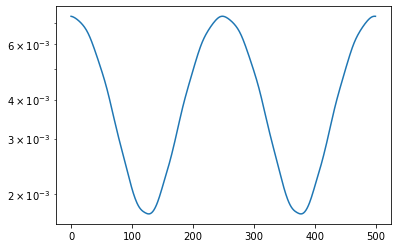

In [99]:
print(all_hidden.keys())
print(all_hidden['L0_0'].shape)
print(all_hidden['L0_1'].shape)

# mse = np.mean(((data_this - decoded_0_1)**2).detach().numpy(), axis=(1,2,3))
# plt.plot(mse)
# mse = np.mean(((data_this - forward_0_1)**2).detach().numpy(), axis=(1,2,3))
# plt.semilogy(mse)
# plt.show()
mse = np.mean(((encoded_0_0 - all_hidden['L0_0'])**2).detach().numpy(), axis=(1,2,3))
plt.semilogy(mse)

plt.show()


level =  0
x shape =  torch.Size([500, 1, 31, 31])
level =  0


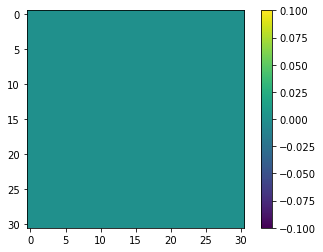

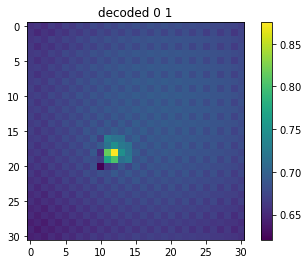

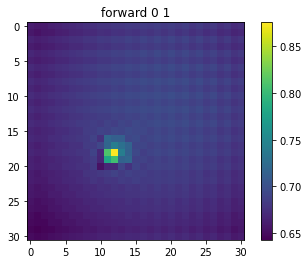

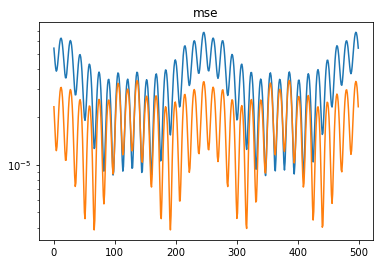

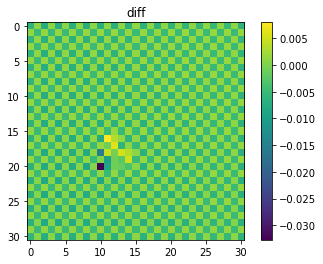

In [64]:
model = models['model_L0_0']
data = torch.tensor(scaled_Phi).T.unsqueeze(1).float()
data_this = obtain_data_at_current_level(data, 0,3)
encoded_0_0 = model.encode(data_this, 0)
decoded_0_0 = model.decode(encoded_0_0, 0)

forward_0_0,_,_,_ = model.forward(data_this, 0)

plt.imshow((forward_0_0 - decoded_0_0)[0,0].detach().numpy())
plt.colorbar()
plt.show()

model = models['model_L0_1']
# data_this = obtain_data_at_current_level(data, 0,3)
encoded_0_1 = encode(model, data_this, 0)#, query_in_out_each_level=False, query_hidden=False)

decoded_0_1 = decode(model, encoded_0_1, 0, forward_0_0)

forward_0_1,_,_,_ = model.forward(data_this, 0)

plt.imshow(decoded_0_1[0,0].detach().numpy())
plt.title("decoded 0 1")
plt.colorbar()
plt.show()

plt.imshow(forward_0_1[0,0].detach().numpy())
plt.title("forward 0 1")
plt.colorbar()
plt.show()

mse = np.mean(((data_this - decoded_0_1)**2).detach().numpy(), axis=(1,2,3))
plt.plot(mse)
mse = np.mean(((data_this - forward_0_1)**2).detach().numpy(), axis=(1,2,3))
plt.semilogy(mse)
plt.title("mse")
plt.show()

diff = (decoded_0_1 - forward_0_1)
plt.imshow(diff[0,0].detach().numpy())
plt.title("diff")
plt.colorbar()
# print(encoded.shape)
# plt.imshow(encoded[0,0].detach().numpy())
# plt.colorbar()
# plt.show()
# for i in range(15):
#     for j in range(15):
#         if torch.abs(encoded_0_1[0,0,i,j]) >0:
#             plt.plot(encoded_0_1[:,0,i,j].detach().numpy())
# #             plt.plot(encoded_0_0[:,0,i,j].detach().numpy())
# #             plt.show()
# #             hjk

level =  0
x shape =  torch.Size([500, 1, 31, 31])
level =  0


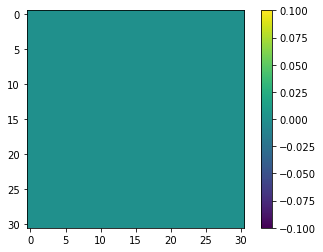

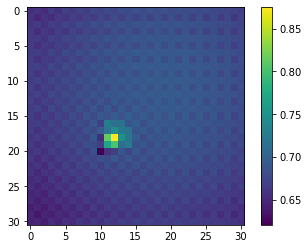

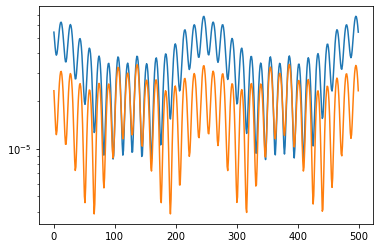

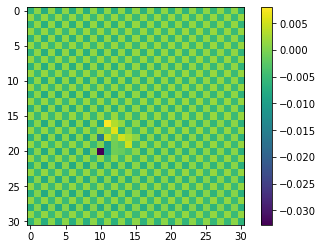

In [63]:
model = models['model_L0_0']
data = torch.tensor(scaled_Phi).T.unsqueeze(1).float()
data_this = obtain_data_at_current_level(data, 0,3)
encoded_0_0 = model.encode(data_this, 0)
decoded_0_0 = model.decode(encoded_0_0, 0)

forward_0_0,_,_,_ = model.forward(data_this, 0)

plt.imshow((forward_0_0 - decoded_0_0)[0,0].detach().numpy())
plt.colorbar()
plt.show()

model = models['model_L0_1']
# data_this = obtain_data_at_current_level(data, 0,3)
encoded_0_1 = encode(model, data_this, 0)#, query_in_out_each_level=False, query_hidden=False)

decoded_0_1 = decode(model, encoded_0_1, 0, forward_0_0)

forward_0_1,_,_,_ = model.forward(data_this, 0)

plt.imshow(decoded_0_1[0,0].detach().numpy())
plt.colorbar()
plt.show()

mse = np.mean(((data_this - decoded_0_1)**2).detach().numpy(), axis=(1,2,3))
plt.plot(mse)
mse = np.mean(((data_this - forward_0_1)**2).detach().numpy(), axis=(1,2,3))
plt.semilogy(mse)
plt.show()

diff = (decoded_0_1 - forward_0_1)
plt.imshow(diff[0,0].detach().numpy())
plt.colorbar()
# print(encoded.shape)
# plt.imshow(encoded[0,0].detach().numpy())
# plt.colorbar()
# plt.show()
# for i in range(15):
#     for j in range(15):
#         if torch.abs(encoded_0_1[0,0,i,j]) >0:
#             plt.plot(encoded_0_1[:,0,i,j].detach().numpy())
# #             plt.plot(encoded_0_0[:,0,i,j].detach().numpy())
# #             plt.show()
# #             hjk

level =  0
x shape =  torch.Size([500, 1, 31, 31])
encoded.shape =  torch.Size([500, 1, 15, 15])
level =  0
torch.Size([499, 1, 31, 31])
datathis =  torch.Size([500, 1, 31, 31])
level =  0
x shape =  torch.Size([500, 1, 31, 31])
encoded.shape =  torch.Size([500, 1, 15, 15])
level =  0
level =  1
x shape =  torch.Size([500, 1, 63, 63])
encoded.shape =  torch.Size([500, 1, 31, 31])
level =  1
(499,)


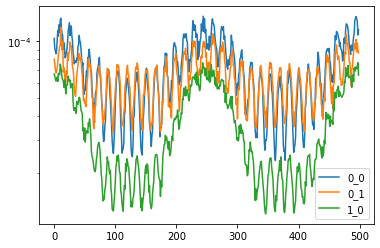

In [71]:
model = models['model_L0_0']
data_this = obtain_data_at_current_level(data, 0,3)
predicted = model.predict_in_middle(data_this, 0)#, query_in_out_each_level=False, query_hidden=False)

mse = np.mean(((data_this[1:] - predicted)**2).detach().numpy(), axis=(1,2,3))

# plt.imshow(encoded[0,0].detach().numpy())
# plt.colorbar()
# plt.show()

# plt.plot(encoded[:,0,0,0].detach().numpy())
# plt.show()

# decoded = model.decode(encoded, 0)

# plt.imshow(decoded[0,0].detach().numpy())
# plt.colorbar()
# plt.show()

print(predicted.shape)
print("datathis = ", data_this.shape)
mse = np.mean(((data_this[1:] - predicted)**2).detach().numpy(), axis=(1,2,3))
plt.plot(mse,label = "0_0")

model = models['model_L0_1']
# data_this = obtain_data_at_current_level(data, 0,3)
predicted = model.predict_in_middle(data_this, 0)#, query_in_out_each_level=False, query_hidden=False)


mse = np.mean(((data_this[1:] - predicted)**2).detach().numpy(), axis=(1,2,3))
plt.semilogy(mse,label = "0_1")


model = models['model_L1_0']
data_this = obtain_data_at_current_level(data, 1,3)
predicted = model.predict_in_middle(data_this, 1)#, query_in_out_each_level=False, query_hidden=False)

mse = np.mean(((data_this[1:] - predicted)**2).detach().numpy(), axis=(1,2,3))
plt.semilogy(mse,label = "1_0")


plt.legend()
print(mse.shape)
# plt.semilogy(mse)

level =  1
x shape =  torch.Size([500, 1, 63, 63])
torch.Size([500, 1, 31, 31])


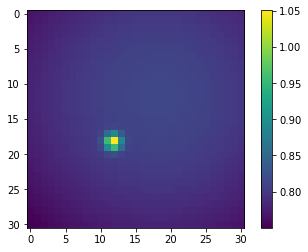

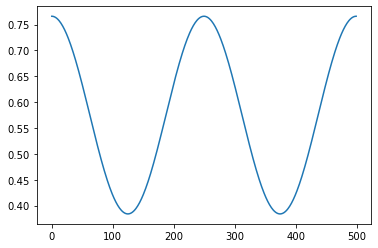

level =  1


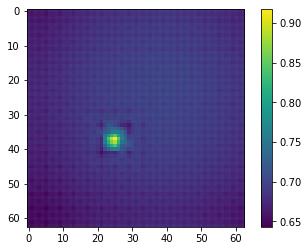

(500,)


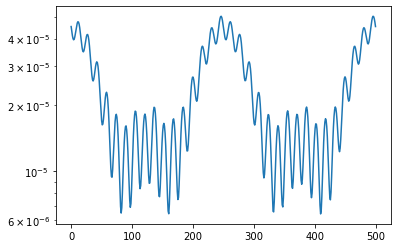

In [11]:
model = models['model_L1_0']
data = torch.tensor(scaled_Phi).T.unsqueeze(1).float()
step_size = 1
data_this = obtain_data_at_current_level(data, 1,3)[::step_size]
encoded = model.encode(data_this, 1)#, query_in_out_each_level=False, query_hidden=False)
print(encoded.shape)

plt.imshow(encoded[0,0].detach().numpy())
plt.colorbar()
plt.show()

plt.plot(encoded[:,0,0,0].detach().numpy())
plt.show()

decoded = model.decode(encoded, 1)

plt.imshow(decoded[0,0].detach().numpy())
plt.colorbar()
plt.show()

mse = np.mean(((data_this - decoded)**2).detach().numpy(), axis=(1,2,3))

print(mse.shape)
plt.semilogy(mse)

In [12]:
print(torch.min(torch.abs(encoded)))

tensor(0.0078, grad_fn=<MinBackward1>)


level =  1
x shape =  torch.Size([500, 1, 63, 63])
encoded.shape =  torch.Size([500, 1, 31, 31])
level =  1
torch.Size([499, 1, 63, 63])


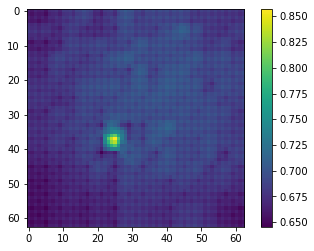

(499,)
(499,)


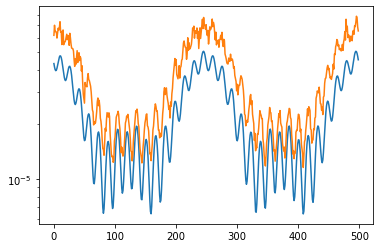

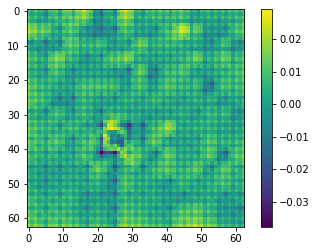

In [13]:
predicted = model.predict_in_middle(data_this, 1)
print(predicted.shape)
plt.imshow(predicted[0,0].detach().numpy())
plt.colorbar()
plt.show()

mse = np.mean(((data_this - decoded)**2)[1:].detach().numpy(), axis=(1,2,3))

print(mse.shape)
plt.semilogy(mse)

mse = np.mean(((data_this[1:] - predicted)**2).detach().numpy(), axis=(1,2,3))

print(mse.shape)
plt.semilogy(mse)
plt.show()
plt.imshow((predicted - data_this[1:])[0,0].detach().numpy() )
plt.colorbar()
plt.show()

In [ ]:
data_this = obtain_data_at_current_level(data, 1,3)
print(decoded.shape)
print(data_this.shape)

mse = np.mean(((data_this - decoded)**2).detach().numpy(), axis=(1,2,3))

print(mse.shape)
plt.semilogy(mse)

In [ ]:
plt.plot(encoded[:,0,0,0].detach().numpy())
x1 = np.arange(500)/360
x2 = encoded[:,0,0,0].detach().numpy()

In [ ]:
from scipy import optimize
def form(x, a, b, c, d):
    return a*np.cos(b*x + c) + d

param, covariance = optimize.curve_fit(form, x1, x2)
plt.scatter(x1*360, x2, label='data')
plt.ylim(x2.min(), x2.max())
plt.plot(x1*360, form(x1, *param), 'b-', label="predicted")
plt.legend()
plt.show()

## Results

In [ ]:
# trained models at different levels
models = {}
print('model names: model_L{level}_{index}')
for file_name in sorted(os.listdir(model_path)):
    model_name, _ = file_name.split('.')
    print(model_name)
    models[model_name] = torch.load(os.path.join(model_path, file_name))

In [ ]:
# choose the finest model
model = models['model_L2_3']

# resolved maps at different levels (that suggest poorly reconstructed regions)
for i in range(3):
    print(model.resolved_maps[str(i)].keys())

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pcolor(model.resolved_maps['0']['0'].cpu().detach().numpy(), cmap='binary', vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(os.path.join(result_path, 'L0_I0.png'))


fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pcolor(model.resolved_maps['0']['1'].cpu().detach().numpy(), cmap='binary', vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(os.path.join(result_path, 'L0_I1.png'))


fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pcolor(model.resolved_maps['1']['0'].cpu().detach().numpy(), cmap='binary', vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(os.path.join(result_path, 'L1_I0.png'))


fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pcolor(model.resolved_maps['1']['1'].cpu().detach().numpy(), cmap='binary', vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(os.path.join(result_path, 'L1_I1.png'))


fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pcolor(model.resolved_maps['1']['2'].cpu().detach().numpy(), cmap='binary', vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(os.path.join(result_path, 'L1_I2.png'))

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pcolor(model.resolved_maps['2']['0'].cpu().detach().numpy(), cmap='binary', vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(os.path.join(result_path, 'L2_I0.png'))

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pcolor(model.resolved_maps['2']['1'].cpu().detach().numpy(), cmap='binary', vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(os.path.join(result_path, 'L2_I1.png'))

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pcolor(model.resolved_maps['2']['2'].cpu().detach().numpy(), cmap='binary', vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(os.path.join(result_path, 'L2_I2.png'))

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pcolor(model.resolved_maps['2']['3'].cpu().detach().numpy(), cmap='binary', vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(os.path.join(result_path, 'L2_I3.png'))

In [ ]:
# reconstructions of test snapshots

inds = np.array(sorted(dataset.test_inds))
dataset.test_inds = inds
n_snapshots = len(inds)
n_samples = 6
n_step = n_snapshots // 6

fig, axes = plt.subplots(1, n_samples, figsize=(n_samples*11, 10))
plt.subplots_adjust(wspace=0.01)
for i in range(n_samples):
    axes[i].pcolor(dataset.data[inds[i*n_step], :, :, :].squeeze().cpu().detach().numpy(), cmap='viridis')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
fig.savefig(os.path.join(result_path, 'test_samples.png'), bbox_inches='tight')


model = models['model_L0_1']
fig, axes = plt.subplots(1, n_samples, figsize=(n_samples*11, 10))
plt.subplots_adjust(wspace=0.01)
for i in range(n_samples):
    _, _, data = dataset.obtain_data_at_current_level(level=0)
    output, _, _, _ = model(data[[i*n_step], :, :, :], model.cur_level)
    axes[i].pcolor(output.squeeze().cpu().detach().numpy(), cmap='viridis')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
fig.savefig(os.path.join(result_path, 'test_L0_reconstructions.png'), bbox_inches='tight')


model = models['model_L1_2']
fig, axes = plt.subplots(1, n_samples, figsize=(n_samples*11, 10))
plt.subplots_adjust(wspace=0.01)
for i in range(n_samples):
    _, _, data = dataset.obtain_data_at_current_level(level=1)
    output, _, _, _ = model(data[[i*n_step], :, :, :], model.cur_level)
    axes[i].pcolor(output.squeeze().cpu().detach().numpy(), cmap='viridis')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
fig.savefig(os.path.join(result_path, 'test_L1_reconstructions.png'), bbox_inches='tight')


model = models['model_L2_3']
fig, axes = plt.subplots(1, n_samples, figsize=(n_samples*11, 10))
plt.subplots_adjust(wspace=0.01)
for i in range(n_samples):
    _, _, data = dataset.obtain_data_at_current_level(level=2)
    output, _, _, _ = model(data[[i*n_step], :, :, :], model.cur_level)
    axes[i].pcolor(output.squeeze().cpu().detach().numpy(), cmap='viridis')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
fig.savefig(os.path.join(result_path, 'test_L2_reconstructions.png'), bbox_inches='tight')

In [ ]:
fig1, axes = plt.subplots(2, 1, figsize=(8, 16))
axes[0].pcolor(xgrid[:,:,0], ygrid[:,:,0], phi1(xgrid, ygrid, tgrid)[:, :, 0].T, cmap='viridis')
axes[1].pcolor(xgrid[:,:,0], ygrid[:,:,0], phi2(xgrid, ygrid, tgrid)[:, :, 0].T, cmap='viridis')

axes[0].set_xticks([])
axes[1].set_xticks([])
axes[0].set_yticks([])
axes[1].set_yticks([])

fig1.savefig(os.path.join(result_path, 'spatial_dynamics.png'))

fig2, axes = plt.subplots(2, 1, figsize=(14*7, 24))
axes[0].plot(t, np.cos(w0*t), t[inds[::n_step]], np.cos(w0*t[inds[::n_step]]), 'r.', linewidth=20, markersize=80)
axes[1].plot(t, np.cos(w1*t + np.pi/4), t[inds[::n_step]], np.cos(w1*t[inds[::n_step]] + np.pi/4), 'r.', linewidth=20, markersize=80)
#
axes[0].set_xticks([])
axes[1].set_xticks([])
axes[0].set_yticks([])
axes[1].set_yticks([])

fig2.savefig(os.path.join(result_path, 'temporal_dynamics.png'))

In [ ]:
records = {}
for file_name in sorted(os.listdir(result_path)):
    if file_name.endswith('.dat'):
        key, _ = file_name.split('.')
        with open(os.path.join(result_path, file_name), 'rb') as f: 
            records[key]= pickle.load(f)

In [ ]:
n_colors = 4
colors = [(51/255, 51/255, 255/255)]+ \
         [(204/255, 153/255, 255/255), 
          (178/255, 102/255, 255/255),
          (153/255, 51/255, 255/255),
          (127/255, 0/255, 255/255),
          (102/255, 0/255, 204/255),
          (76/255, 0/255, 153/255)]

fig1, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(80, 16))

# plot
s = 0
for i in range(3):
    level_errs = records['val_errs'][i]
    n_widens = len(level_errs)
    ax1.axvline(x=s, color='k', linestyle='--', linewidth=20)
    for j in range(n_widens):
        op_err = level_errs[j]
        ax1.plot(range(s, s + len(op_err)), np.log(op_err), color=colors[j], linewidth=20)
        s += len(op_err)
        
ax1.axvline(x=s-1, color='k', linestyle='--', linewidth=20)

ax1.xaxis.set_tick_params(labelsize=100)
ax1.yaxis.set_tick_params(labelsize=100)

fig1.savefig(os.path.join(result_path, 'err_iter_plot.png'))